In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action="ignore")

ModuleNotFoundError: No module named 'plotly'

In [ ]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')

In [ ]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


***Data Exploration***

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [ ]:
df.isna().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

In [ ]:
df.duplicated().sum()

0

***EDA & INSIGHTS***

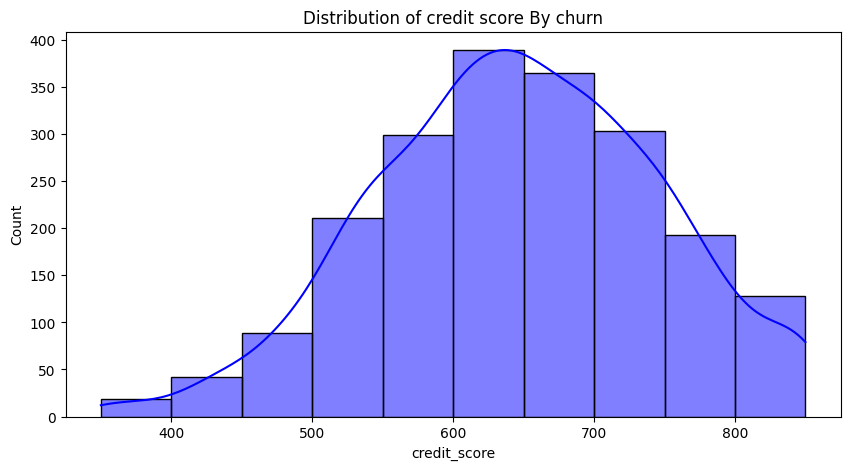

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['credit_score'][df['churn'] == 1], bins=10, kde=True, color="blue")
plt.title('Distribution of credit score By churn')
plt.show()

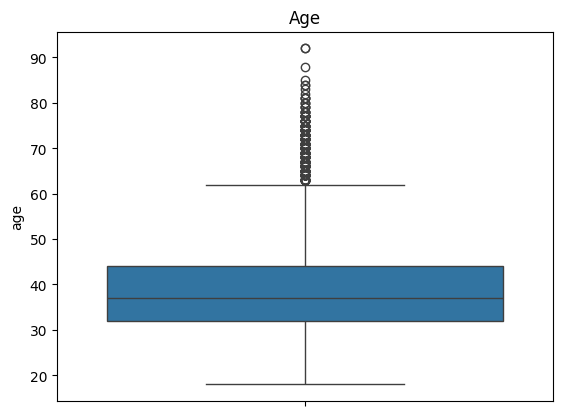

In [ ]:
sns.boxplot(df['age'])
plt.title('Age')
plt.show()

In [ ]:
df.drop(columns=['customer_id'],inplace=True)

In [ ]:
country=df['country'].value_counts()

In [ ]:
index=df['country'][df['churn']==1].value_counts().index
fig = px.bar(df['country'][df['churn']==1].value_counts(),
             template='plotly_dark',
             labels = {'value':'Count'},
             text_auto = True,
             color=index,
             title='Is Country Effect on Churn?')
pio.renderers.default = 'iframe'
fig.show()

In [ ]:
import pickle

# Assuming 'model' is your trained XGBoost model from the notebook
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [ ]:
gender=df['gender'].value_counts()

In [ ]:
val=df['gender'][df['churn']==1].value_counts().values
index=df['gender'][df['churn']==1].value_counts().index
fig = px.pie(values=val,names=index,template='plotly_dark',title='Is Gender Effect on Churn?').update_traces(textinfo='label+percent')
fig.show()

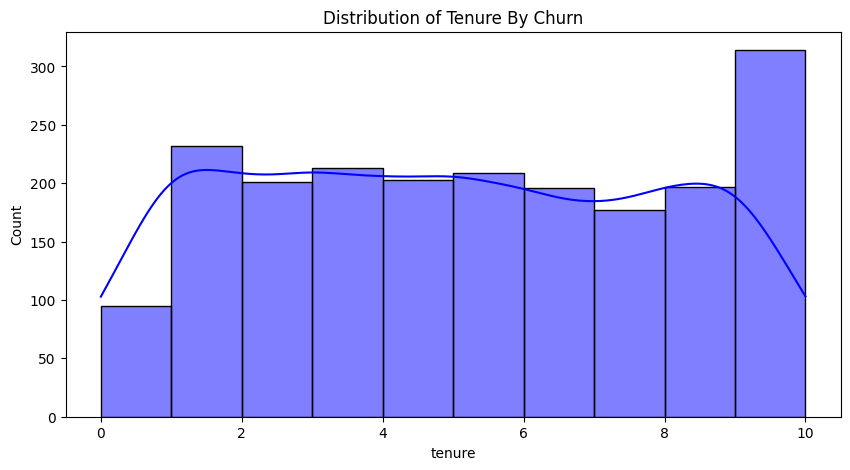

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['tenure'][df['churn'] == 1], bins=10, kde=True, color="blue")
plt.title('Distribution of Tenure By Churn')
plt.show()

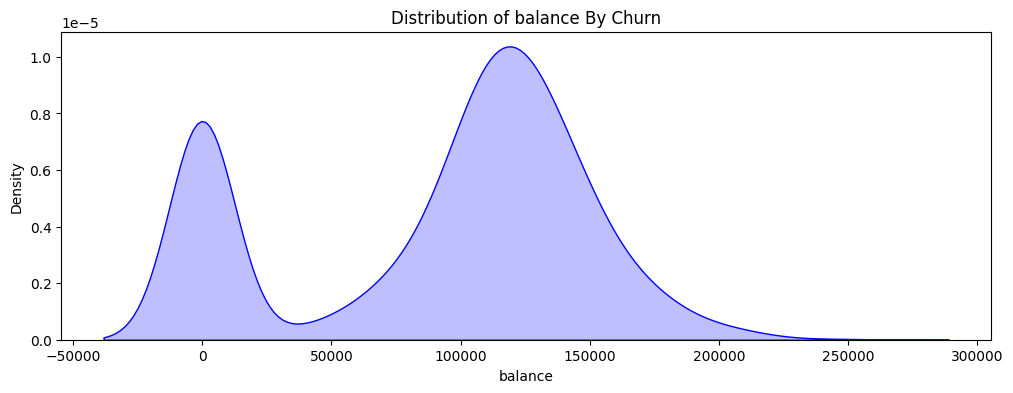

In [ ]:
plt.figure(figsize=(12, 4))

sns.kdeplot(df['balance'][df['churn'] == 1], color='blue', fill=True)
plt.title('Distribution of balance By Churn')

plt.show()

In [ ]:
val=df['active_member'][df['churn']==1].value_counts().values
index=df['active_member'][df['churn']==1].value_counts().index
index = index.to_series().replace({0: "Non-Active", 1: "Active"})
fig = px.pie(
             values=val,
             names=index,
             template='plotly_dark',
             title='Is activation effect on Churn?'
            ).update_traces(textinfo='label+percent')
fig.show()

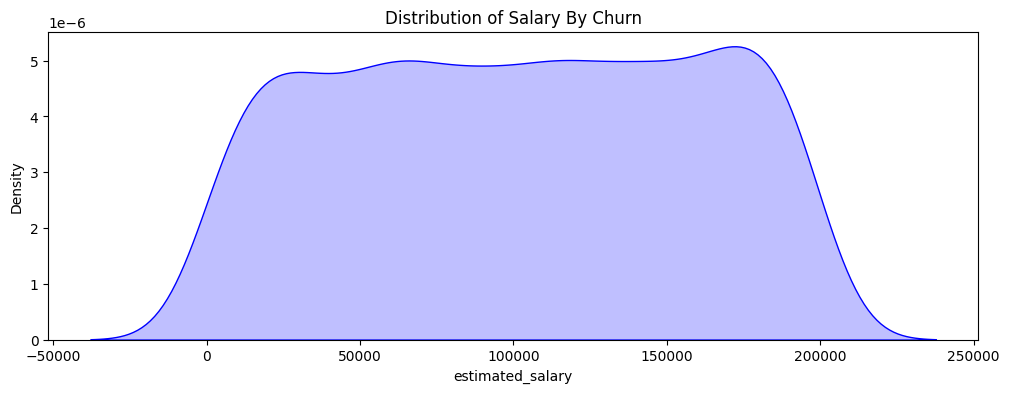

In [ ]:
plt.figure(figsize=(12, 4))

sns.kdeplot(df['estimated_salary'][df['churn'] == 1], color='blue', fill=True)
plt.title('Distribution of Salary By Churn')
 
plt.show()

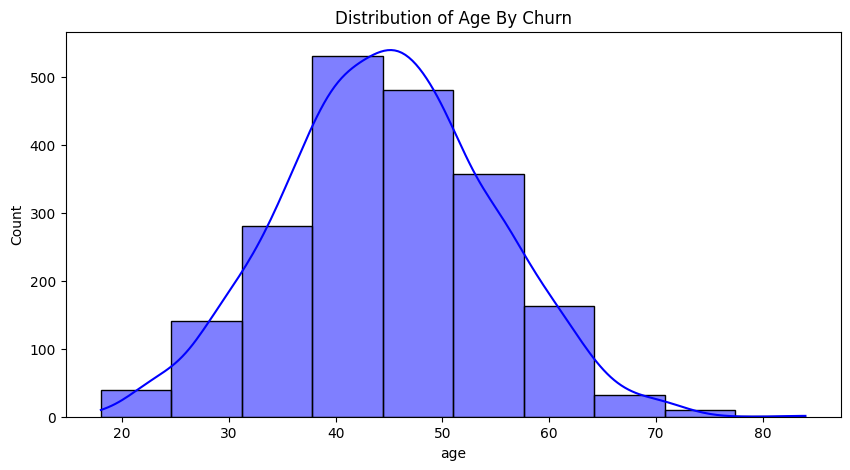

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df['age'][df['churn'] == 1], bins=10, kde=True, color="blue")
plt.title('Distribution of Age By Churn')
plt.show()

In [ ]:
fig=px.bar(df['churn'].value_counts(),
           template='plotly_dark',
           color=df['churn'].value_counts().index,
           labels = {'value':'Count'},
           text_auto=True,
           title='Churn'
          )
pio.renderers.default = 'iframe'
fig.show()

***Preprocessing***

In [ ]:
numeric_columns=df.select_dtypes(include=['number']).columns
numeric_columns

Index(['credit_score', 'age', 'tenure', 'balance', 'products_number',
       'credit_card', 'active_member', 'estimated_salary', 'churn'],
      dtype='object')

***Remove Outliers***

In [ ]:
#Handaling outlier
def outliers_handler(real_data:pd.DataFrame(),col_name:str)->pd.DataFrame():
    data=real_data.copy()
    q1 = np.percentile(data[col_name],25)
    q3 = np.percentile(data[col_name],75)
    iqr = q3-q1
    upper_bound = q3+(1.5*iqr)
    lower_bound = q1-(1.5*iqr)
    outliers = (data[col_name]>upper_bound) | (data[col_name]<lower_bound)
    num_of_outliers = len(data[outliers])
    if num_of_outliers <= len(data)*0.1:
        data = data[~outliers]
        print("Outliers dropped")
    else:
        data.loc[data[col_name]>upper_bound,col_name] = upper_bound
        data.loc[data[col_name]<lower_bound,col_name] = lower_bound
        print("Outliers replaced")
    return data
for i in numeric_columns:
    if i=='churn':
        break
    df=outliers_handler(df,i)

Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped
Outliers dropped


***Encoding Categorical Columns***

In [ ]:
categorical_columns=df.select_dtypes(include='object').columns

In [ ]:
le = LabelEncoder()

In [ ]:
for col in categorical_columns:
    df[col]=le.fit_transform(df[col])

In [ ]:
df.head()

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


***Spliting Data***

In [ ]:
x=df.drop(columns=['churn']) 
y=df['churn']

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

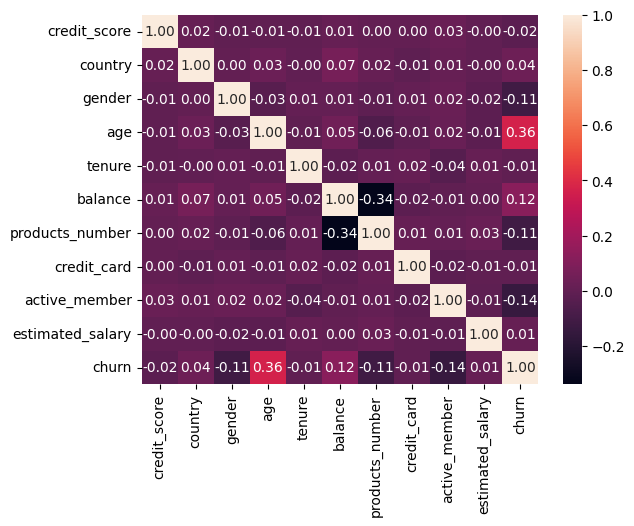

In [ ]:
combined = pd.concat([x_train,y_train], axis=1)

correlation_matrix = combined.corr() 
sns.heatmap(correlation_matrix,annot=True,fmt='.2f')
plt.show()

***scaling***

In [ ]:
sc=StandardScaler()

In [ ]:
x_train=sc.fit_transform(x_train)
x_test=sc.transform(x_test)

***Modeling***

In [ ]:
def evaluate_model(model,pred):
    print(f'Accuracy Train Score : {model.score(x_train,y_train)}\n')
    print(f'Accuracy Test Score : {model.score(x_test,y_test)}\n')
    print(f'Classification Report: \n{classification_report(y_test,pred)}\n')
    cm=confusion_matrix(pred,y_test)
    sns.heatmap(cm,annot=True,fmt='d')
    plt.show()

In [ ]:
lr=LogisticRegression()

In [ ]:
lr.fit(x_train,y_train)

LogisticRegression()

In [ ]:
y_pred_lr=lr.predict(x_test)

Accuracy Train Score : 0.8309380715965509

Accuracy Test Score : 0.8187042842215256

Classification Report: 
              precision    recall  f1-score   support

           0       0.84      0.96      0.89      1535
           1       0.60      0.26      0.36       379

    accuracy                           0.82      1914
   macro avg       0.72      0.61      0.63      1914
weighted avg       0.79      0.82      0.79      1914




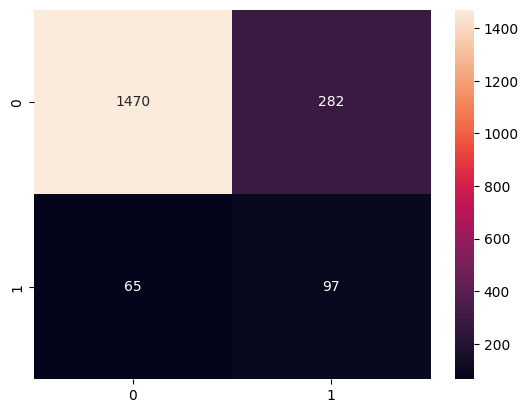

In [ ]:
evaluate_model(lr,y_pred_lr)

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(x_train,y_train)

DecisionTreeClassifier()

In [ ]:
y_pred_dt=dt.predict(x_test)

Accuracy Train Score : 1.0

Accuracy Test Score : 0.7842215256008359

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      1535
           1       0.46      0.46      0.46       379

    accuracy                           0.78      1914
   macro avg       0.66      0.66      0.66      1914
weighted avg       0.79      0.78      0.78      1914




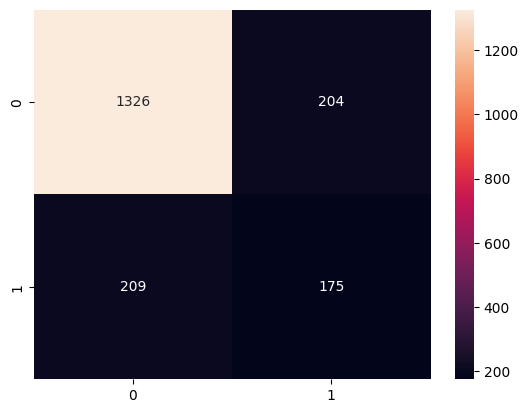

In [ ]:
evaluate_model(dt,y_pred_dt)

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)
y_pred_rf = rf.predict(x_test)

Accuracy Train Score : 1.0

Accuracy Test Score : 0.8531870428422152

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1535
           1       0.73      0.41      0.52       379

    accuracy                           0.85      1914
   macro avg       0.80      0.68      0.72      1914
weighted avg       0.84      0.85      0.84      1914




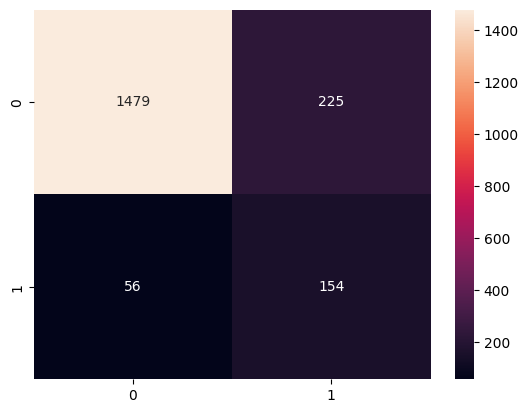

In [ ]:
evaluate_model(rf,y_pred_rf)

In [ ]:
import xgboost as xgb

In [ ]:
model=xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6)

In [ ]:
model.fit(x_train,y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [ ]:
y_pred_xgb=model.predict(x_test)

Accuracy Train Score : 0.903579827541155

Accuracy Test Score : 0.8547544409613375

Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      1535
           1       0.71      0.45      0.55       379

    accuracy                           0.85      1914
   macro avg       0.79      0.70      0.73      1914
weighted avg       0.84      0.85      0.84      1914




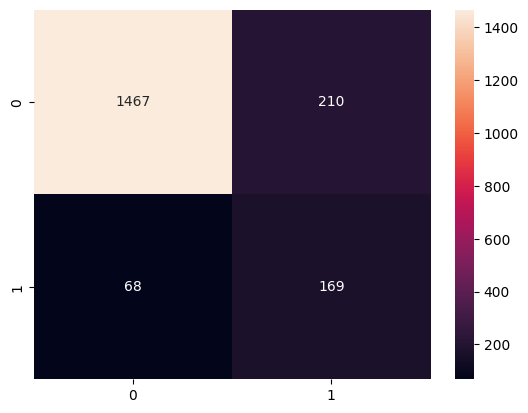

In [ ]:
evaluate_model(model,y_pred_xgb)